In [1]:
# 导入库
import os
import math
import argparse
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

In [2]:
# 定义VRPDataset类
class VRPDataset(Dataset):
    def __init__(self, num_samples, num_nodes, max_load=30, max_demand=9, seed=42):
        super().__init__()
        assert max_load >= max_demand, 'Max load should be greater than or equal to max demand'
        
        self.num_samples = num_samples
        
        generator = torch.Generator()
        generator.manual_seed(seed)
        
        # location: (num_samples, num_nodes + 1, 2)
        location = torch.rand((num_samples, num_nodes + 1, 2), generator=generator)
        # depot: (num_samples, 2)
        self.depot = location[:, 0, :]
        # customer: (num_samples, num_nodes, 2)
        self.customer = location[:, 1:, :]
        # demand: (num_samples, num_nodes)
        self.demand = torch.randint(1, max_demand + 1, (num_samples, num_nodes), generator=generator)
        self.demand = self.demand / max_load
        
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        return self.depot[idx], self.customer[idx], self.demand[idx]

In [3]:
# 定义update_vrp函数
def update_vrp(capacity, demand, idxs):
    # capacity: (batch_size,)
    # demand: (batch_size, num_nodes)
    # idxs: (batch_size,)
    batch_size, num_nodes = demand.size()
    seq_len = num_nodes + 1
    
    # selected_demand: (batch_size,)
    selected_demand = demand[torch.arange(batch_size), idxs - 1]
    
    # not_depot: (batch_size,)
    not_depot = idxs.ne(0)
    if not_depot.any():
        new_capacity = torch.clamp(capacity - selected_demand, min=0)
        new_demand = torch.clamp(selected_demand - capacity, min=0)
        capacity[not_depot] = new_capacity[not_depot]
        demand[torch.arange(batch_size, device=demand.device)[not_depot], idxs[not_depot] - 1] = new_demand[not_depot]
        
    # at_depot: (batch_size,)
    at_depot = ~not_depot
    if at_depot.any():
        capacity[at_depot] = 1.
        
    if demand.eq(0).all():
        # mask: (batch_size, seq_len)
        mask = torch.ones(batch_size, seq_len, dtype=torch.bool, device=idxs.device)
    else:
        # mask: (batch_size, num_nodes)
        mask = demand.eq(0) | demand.gt(capacity.unsqueeze(1).expand(-1, num_nodes))
        # mask_depot: (batch_size,)
        mask_depot = idxs.eq(0)
        # has_no_demand: (batch_size,)
        has_no_demand = demand.sum(dim=1).eq(0)
        mask_depot[has_no_demand] = False
        # mask: (batch_size, seq_len)
        mask = torch.cat((mask_depot.unsqueeze(1), mask), dim=1)
        
    return capacity, demand, mask

In [4]:
# 定义reward函数
def reward(location, idxs):
    # location: (batch_size, seq_len, 2)
    # idxs: (batch_size, num_steps)
    batch_size, seq_len, _ = location.size()
    num_steps = idxs.size(1)
    
    # expanded_idxs: (batch_size, num_steps, 2)
    expanded_idxs = idxs.unsqueeze(2).expand(-1, -1, 2)
    # tour: (batch_size, num_steps, 2)
    tour = torch.gather(location, 1, expanded_idxs)
    # depot: (batch_size, 2)
    depot = location[:, 0, :]
    
    # distances: (batch_size,)
    distances = torch.norm(tour[:, 1:, :] - tour[:, :-1, :], dim=2).sum(dim=1)
    distances += torch.norm(depot - tour[:, 0, :], dim=1)
    distances += torch.norm(depot - tour[:, -1, :], dim=1)
    
    return distances

In [5]:
# 定义ResidualConnection类
class ResidualConnection(nn.Module):
    def __init__(self, module):
        super().__init__()
        
        self.module = module
    
    def forward(self, x):
        return x + self.module(x)

In [6]:
# 定义Normalization类
class Normalization(nn.Module):
    def __init__(self, embedding_size, normalization='batch'):
        super().__init__()
        
        normalizer = {
            'batch': nn.BatchNorm1d,
            'instance': nn.InstanceNorm1d,
        }.get(normalization, None)
        assert normalizer is not None, f'Unsupported normalization type: {normalization}'
        
        self.normalizer = normalizer(embedding_size, affine=True)
        
        self._init_parameters()
        
    def _init_parameters(self):
        if hasattr(self.normalizer, 'weight') and self.normalizer.weight is not None:
            nn.init.uniform_(self.normalizer.weight, 0., 1.)
        if hasattr(self.normalizer, 'bias') and self.normalizer.bias is not None:
            nn.init.zeros_(self.normalizer.bias)
            
    def forward(self, x):
        if isinstance(self.normalizer, nn.BatchNorm1d):
            return self.normalizer(x.view(-1, x.size(-1))).view(*x.size())
        else:
            return self.normalizer(x.permute(0, 2, 1)).permute(0, 2, 1)

In [7]:
# 定义MultiHeadAttention类
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, query_size, key_size, value_size, embedding_size, dropout=0.1):
        super().__init__()
        assert embedding_size % num_heads == 0
        
        self.num_heads = num_heads
        self.embedding_size = embedding_size
        self.head_size = embedding_size // num_heads
        
        self.W_q = nn.Linear(query_size, embedding_size)
        self.W_k = nn.Linear(key_size, embedding_size)
        self.W_v = nn.Linear(value_size, embedding_size)
        self.W_o = nn.Linear(embedding_size, embedding_size)
        self.dropout = nn.Dropout(dropout)
        
        self.scale_factor = math.sqrt(self.head_size)
        
        self._init_parameters()
        
    def _init_parameters(self):
        for param in self.parameters():
            std = 1. / math.sqrt(param.size(-1))
            param.data.uniform_(-std, std)
        
    def forward(self, q, k=None, v=None, mask=None):
        # q: (batch_size, q_len, query_size)
        # k: (batch_size, seq_len, key_size)
        # v: (batch_size, seq_len, value_size)
        # mask: (batch_size, seq_len)
        if k is None:
            k = q
            v = q
        q_len = q.size(1)
        batch_size, seq_len, _ = k.size()
        
        # Q: (batch_size, q_len, embedding_size)
        Q = self.W_q(q)
        # K, V: (batch_size, seq_len, embedding_size)
        K = self.W_k(k)
        V = self.W_v(v)
        
        # Q: (batch_size, num_heads, q_len, head_size)
        Q = Q.view(batch_size, q_len, self.num_heads, self.head_size).transpose(1, 2)
        # K, V: (batch_size, num_heads, seq_len, head_size)
        K = K.view(batch_size, seq_len, self.num_heads, self.head_size).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.head_size).transpose(1, 2)
        
        # attn_scores: (batch_size, num_heads, q_len, seq_len)
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale_factor
        if mask is not None:
            # mask: (batch_size, num_heads, q_len, seq_len)
            mask = mask.unsqueeze(1).unsqueeze(1).expand(-1, self.num_heads, q_len, -1)
            mask_clone = mask.clone().bool()
            attn_scores = attn_scores.masked_fill(mask_clone, float('-inf'))
            
        # attn_weights: (batch_size, num_heads, q_len, seq_len)
        attn_weights = F.softmax(attn_scores, -1)
        attn_weights = self.dropout(attn_weights)
        
        # attn_output: (batch_size, num_heads, q_len, head_size)
        attn_output = torch.matmul(attn_weights, V)
        # attn_output: (batch_size, q_len, embedding_size)
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, q_len, self.embedding_size)
        
        # output: (batch_size, q_len, embedding_size)
        output = self.W_o(attn_output)
        
        return output

In [8]:
# 定义MultiHeadAttentionLayer类
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, num_heads, embedding_size, FF_hidden_size=512, normalization='batch', dropout=0.1):
        super().__init__()
        
        self.attention = ResidualConnection(
            MultiHeadAttention(num_heads, embedding_size, embedding_size, embedding_size, embedding_size, dropout)
        )
        self.norm1 = Normalization(embedding_size, normalization)
        
        self.feed_forward = ResidualConnection(
            nn.Sequential(
                nn.Linear(embedding_size, FF_hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(FF_hidden_size, embedding_size),
            ) if FF_hidden_size > 0 else nn.Linear(embedding_size, embedding_size)
        )
        self.norm2 = Normalization(embedding_size, normalization)
        
    def forward(self, x):
        x = self.norm1(self.attention(x))
        x = self.norm2(self.feed_forward(x))
        return x

In [9]:
# 定义Encoder类
class Encoder(nn.Module):
    def __init__(self, num_heads, embedding_size, num_layers, input_size, FF_hidden_size=512, normalization='batch', dropout=0.1):
        super().__init__()
        
        self.embedding_depot = nn.Linear(input_size, embedding_size)
        self.embedding_customer = nn.Linear(input_size + 1, embedding_size)
        
        self.layers = nn.Sequential(*(
            MultiHeadAttentionLayer(num_heads, embedding_size, FF_hidden_size, normalization, dropout)
            for _ in range(num_layers)
        ))
        
    def forward(self, depot, customer, demand):
        # depot: (batch_size, input_size)
        # customer: (batch_size, num_nodes, input_size)
        # demand: (batch_size, num_nodes)
        
        # embedded_depot: (batch_size, embedding_size)
        embedded_depot = self.embedding_depot(depot)
        # embedded_customer: (batch_size, num_nodes, embedding_size)
        embedded_customer = self.embedding_customer(torch.cat((customer, demand.unsqueeze(-1)), dim=2))
        # embedded: (batch_size, num_nodes + 1, embedding_size)
        embedded = torch.cat((embedded_depot.unsqueeze(1), embedded_customer), dim=1)
        # node_embedding: (batch_size, num_nodes + 1, embedding_size)
        node_embedding = self.layers(embedded)
        
        return node_embedding

In [10]:
# 定义Decoder类
class Decoder(nn.Module):
    def __init__(self, num_heads, embedding_size, update_vrp, C=10, dropout=0.1, temperature=None, argmax=False):
        super().__init__()
        assert embedding_size % num_heads == 0
        
        self.num_heads = num_heads
        self.embedding_size = embedding_size
        self.update_vrp = update_vrp
        self.C = C
        self.temperature = temperature
        self.argmax = argmax
        
        self.multihead_attention = MultiHeadAttention(num_heads, 2 * embedding_size + 1, embedding_size, embedding_size, embedding_size, dropout)
        
        self.W_q = nn.Linear(embedding_size, embedding_size)
        self.W_k = nn.Linear(embedding_size, embedding_size)
        self.scale_factor = math.sqrt(embedding_size)
        
        self._init_parameters()
        
    def _init_parameters(self):
        for param in self.parameters():
            std = 1. / math.sqrt(param.size(-1))
            param.data.uniform_(-std, std)
    
    def forward(self, node_embedding, demand):
        # node_embedding: (batch_size, seq_len, embedding_size)
        # demand: (batch_size, seq_len - 1)
        batch_size, seq_len, embedding_size = node_embedding.size()
        assert self.embedding_size == embedding_size
        
        # graph_embedding: (batch_size, embedding_size)
        graph_embedding = node_embedding.mean(dim=1)
        
        # capacity: (batch_size,)
        capacity = torch.ones(batch_size, dtype=torch.float32, device=node_embedding.device)
        # mask: (batch_size, seq_len)
        mask = torch.zeros(batch_size, seq_len, dtype=torch.bool, device=node_embedding.device)
        mask[:, 0] = True
        
        # node_context: (batch_size, embedding_size)
        node_context = node_embedding[:, 0, :]
        prev_probs, prev_idxs = [], []
        max_steps = 100
        
        for _ in range(max_steps):
            
            if mask.bool().all():
                break
            
            # context_embedding: (batch_size, 2 * embedding_size + 1)
            context_embedding = torch.cat((graph_embedding, node_context, capacity.unsqueeze(1)), dim=1)
            # attn_output: (batch_size, embedding_size)
            attn_output = self.multihead_attention(context_embedding.unsqueeze(1), node_embedding, node_embedding, mask).squeeze(1)
            
            # query: (batch_size, embedding_size)
            query = self.W_q(attn_output)
            # key: (batch_size, seq_len, embedding_size)
            key = self.W_k(node_embedding)
            
            # logits: (batch_size, seq_len)
            logits = torch.matmul(query.unsqueeze(1), key.permute(0, 2, 1)).squeeze(1) / self.scale_factor
            logits = self.C * torch.tanh(logits)
            mask_clone = mask.clone().bool()
            logits = logits.masked_fill(mask_clone, float('-inf'))
            
            # probs: (batch_size, seq_len)
            probs = F.softmax(logits, dim=-1) if self.temperature is None else F.softmax(logits / self.temperature, dim=-1)
            # idxs: (batch_size,)
            if self.argmax and not self.training:
                idxs = torch.argmax(probs, 1)
            else:
                idxs = torch.multinomial(probs, 1).squeeze(1)
                
            capacity, demand, mask = self.update_vrp(capacity, demand, idxs)
            
            prev_probs.append(probs[torch.arange(batch_size), idxs])
            prev_idxs.append(idxs)
            
            # node_context: (batch_size, embedding_size)
            node_context = node_embedding[torch.arange(batch_size), idxs, :]
            
        # prev_probs, prev_idxs: (batch_size, num_steps)
        prev_probs = torch.stack(prev_probs, dim=1)
        prev_idxs = torch.stack(prev_idxs, dim=1)
        
        return prev_probs, prev_idxs

In [11]:
# 定义Actor类
class Actor(nn.Module):
    def __init__(self, num_heads, embedding_size, num_layers, input_size, FF_hidden_size, normalization, dropout, update_vrp, C, temperature, argmax, reward):
        super().__init__()
        
        self.reward = reward
        
        self.encoder = Encoder(num_heads, embedding_size, num_layers, input_size, FF_hidden_size, normalization, dropout)
        self.decoder = Decoder(num_heads, embedding_size, update_vrp, C, dropout, temperature, argmax)
        
    def forward(self, depot, customer, demand):
        # depot: (batch_size, input_size)
        # customer: (batch_size, num_nodes, input_size)
        # demand: (batch_size, num_nodes)
        
        # node_embedding: (batch_size, seq_len, embedding_size)
        node_embedding = self.encoder(depot, customer, demand)
        # probs, idxs: (batch_size, num_steps)
        probs, idxs = self.decoder(node_embedding, demand)
        # rewards: (batch_size,)
        rewards = self.reward(torch.cat((depot.unsqueeze(1), customer), dim=1), idxs)
        
        return rewards, idxs, probs

In [12]:
# 训练
def train(args, train_dataset, val_dataset, baseline_dataset):
    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False)
    baseline_loader = DataLoader(baseline_dataset, batch_size=args.batch_size, shuffle=False)
    
    actor = Actor(args.num_heads, args.embedding_size, args.num_layers, args.input_size, args.FF_hidden_size, args.normalization, args.dropout, update_vrp, args.C, args.temperature, False, reward).to(args.device)
    baseline_network = Actor(args.num_heads, args.embedding_size, args.num_layers, args.input_size, args.FF_hidden_size, args.normalization, args.dropout, update_vrp, args.C, args.temperature, True, reward).to(args.device)
    baseline_network.load_state_dict(actor.state_dict())
    baseline_network.eval()
    optimizer = optim.Adam(actor.parameters(), lr=args.lr)
    
    step = 0
    best_length = float('inf')
    train_lengths, val_lengths = [], []
    writer = SummaryWriter()
    model_path = os.path.join(args.output_dir, args.name)
    
    for epoch in range(args.n_epochs):
        for batch_id, train_batch in enumerate(train_loader):
            actor.train()
            
            # depot: (batch_size, input_size)
            depot = train_batch[0].to(args.device)
            # customer: (batch_size, num_nodes, input_size)
            customer = train_batch[1].to(args.device)
            # demand: (batch_size, num_nodes)
            demand = train_batch[2].to(args.device)
            # rewards: (batch_size,)
            # idxs, probs: (batch_size, num_steps)
            rewards, idxs, probs = actor(depot, customer, demand.clone())
            # log_probs: (batch_size,)
            log_probs = torch.log(probs.clamp(min=1e-10)).sum(dim=1)
            with torch.no_grad():
                # baseline: (batch_size,)
                baseline, _, _ = baseline_network(depot, customer, demand.clone())
            # advantage: (batch_size,)
            advantage = rewards - baseline
            # reinforce: (batch_size,)
            reinforce = advantage.detach() * log_probs
            actor_loss = reinforce.mean()
            
            optimizer.zero_grad()
            actor_loss.backward()
            torch.nn.utils.clip_grad_norm_(actor.parameters(), args.max_grad_norm)
            optimizer.step()
            
            writer.add_scalar('Actor_Loss/train', actor_loss.item(), step)
            writer.add_scalar('Length/train', rewards.mean().item(), step)
            
            if batch_id % 100 == 0:
                print(f"Epoch [{epoch + 1}/{args.n_epochs}], Batch [{batch_id + 1}/{len(train_loader)}], "
                      f"Actor Loss: {actor_loss.item():.4f}, Reward: {rewards.mean().item():.4f}")
                
                actor.eval()
                with torch.no_grad():
                    total_rewards, total_nums = 0, 0
                    for val_batch in val_loader:
                        depot = val_batch[0].to(args.device)
                        customer = val_batch[1].to(args.device)
                        demand = val_batch[2].to(args.device)
                        rewards, _, _ = actor(depot, customer, demand)
                        total_rewards += rewards.sum().item()
                        total_nums += depot.size(0)
                    avg_reward = total_rewards / total_nums
                    writer.add_scalar('Length/validation', avg_reward, step)
                    print(f"Validation average reward after epoch {epoch + 1}: {avg_reward:.4f}")
                    
                    if avg_reward < best_length:
                        best_length = avg_reward
                        torch.save(actor.state_dict(), model_path)
                        
        actor_rewards, baseline_rewards = [], []
        with torch.no_grad():
            for baseline_batch in baseline_loader:
                depot = baseline_batch[0].to(args.device)
                customer = baseline_batch[1].to(args.device)
                demand = baseline_batch[2].to(args.device)
                actor_r, _, _ = actor(depot, customer, demand.clone())
                baseline_r, _, _ = baseline_network(depot, customer, demand.clone())
                actor_rewards.append(actor_r.cpu())
                baseline_rewards.append(baseline_r.cpu())
        
        actor_rewards = torch.cat(actor_rewards)
        baseline_rewards = torch.cat(baseline_rewards)
        t_stat, p_value = stats.ttest_rel(actor_rewards.numpy(), baseline_rewards.numpy())
        if t_stat < 0:
            p_value_one_sided = p_value / 2
        elif t_stat == 0:
            p_value_one_sided = 0.5
        else:
            p_value_one_sided = 1 - p_value / 2
            
        if p_value_one_sided < args.alpha:
            print(f'Updating baseline network at epoch {epoch + 1}.')
            baseline_network.load_state_dict(actor.state_dict())
        else:
            print(f'Baseline network has not been updated at epoch {epoch + 1}.')
    
    writer.close()

In [13]:
# 参数
args = argparse.Namespace()
args.num_nodes = 20
args.max_load = 30
args.max_demand = 9
args.n_epochs = 100
args.batch_size = 512
args.lr = 1e-4
args.num_heads = 8
args.embedding_size = 128
args.num_layers = 3
args.input_size = 2
args.FF_hidden_size = 512
args.normalization = 'batch'
args.dropout = 0.1
args.C = 10
args.temperature = None
args.max_grad_norm = 1.
args.num_samples = 12800
args.alpha = 0.05
args.output_dir = 'output'
args.name = 'DRL4VRP_Attention_REINFORCE_RolloutBaseline_VRP' + str(args.num_nodes)
args.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

os.makedirs(args.output_dir, exist_ok=True)

train_dataset = VRPDataset(1280000, args.num_nodes, args.max_load, args.max_demand)
val_dataset = VRPDataset(1280, args.num_nodes, args.max_load, args.max_demand)
test_dataset = VRPDataset(1280, args.num_nodes, args.max_load, args.max_demand)
baseline_dataset = VRPDataset(10000, args.num_nodes, args.max_load, args.max_demand)

In [14]:
print('Training started...')
train(args, train_dataset, val_dataset, baseline_dataset)
print('Training completed!')

Training started...
Epoch [1/100], Batch [1/2500], Actor Loss: 22.3672, Reward: 13.6123
Validation average reward after epoch 1: 13.3696
Epoch [1/100], Batch [101/2500], Actor Loss: 99.0905, Reward: 9.3342
Validation average reward after epoch 1: 9.1616
Epoch [1/100], Batch [201/2500], Actor Loss: 99.7851, Reward: 8.5428
Validation average reward after epoch 1: 8.4734
Epoch [1/100], Batch [301/2500], Actor Loss: 84.4474, Reward: 8.3355
Validation average reward after epoch 1: 8.3027
Epoch [1/100], Batch [401/2500], Actor Loss: 83.9352, Reward: 8.2231
Validation average reward after epoch 1: 8.1881
Epoch [1/100], Batch [501/2500], Actor Loss: 86.8217, Reward: 8.1049
Validation average reward after epoch 1: 8.0740
Epoch [1/100], Batch [601/2500], Actor Loss: 89.3682, Reward: 8.0978
Validation average reward after epoch 1: 8.0876
Epoch [1/100], Batch [701/2500], Actor Loss: 84.1207, Reward: 7.9711
Validation average reward after epoch 1: 7.9558
Epoch [1/100], Batch [801/2500], Actor Loss:

In [14]:
# 画VRP示例图
def plot_vrp_paths(args, depot, customer, idxs, rewards):
    # depot: (batch_size, 2)
    # customer: (batch_size, num_nodes, 2)
    # idxs: (batch_size, num_steps)
    # rewards: (batch_size,)
    colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple']
    
    # location: (batch_size, seq_len, 2)
    location = torch.cat((depot.unsqueeze(1), customer), dim=1)
    location = location.cpu().numpy()
    depot = depot.cpu().numpy()
    customer = customer.cpu().numpy()
    if isinstance(idxs, list):
        idxs = [idx.cpu().numpy() if torch.is_tensor(idx) else np.array(idx) for idx in idxs]
    else:
        idxs = idxs.cpu().numpy()
    rewards = rewards.cpu().numpy()
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle(args.name)
    
    for i in range(8):
        ax = axes[i // 4, i % 4]
        coords = location[i]
        path = idxs[i]
        num = 0

        for j in range(1, len(path)):
            if path[j - 1] == 0 and path[j] != 0:
                num += 1
            x1, y1 = coords[path[j - 1]]
            x2, y2 = coords[path[j]]
            ax.plot([x1, x2], [y1, y2], '-', c=colors[num % len(colors)])  
            if j == 1:
                ax.plot([depot[i][0], x1], [depot[i][1], y1], '-', c=colors[num % len(colors)])  
        ax.plot([depot[i][0], x2], [depot[i][1], y2], '-', c=colors[num % len(colors)])
            
        ax.scatter(coords[1:, 0], coords[1:, 1], c='blue') 
        ax.scatter(coords[0, 0], coords[0, 1], c='red')  
        ax.set_title(f'Length: {rewards[i]:.3f}')
        
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [15]:
# 测试 (greedy)
def test1(args, test_dataset):
    test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)
    
    actor = Actor(args.num_heads, args.embedding_size, args.num_layers, args.input_size, args.FF_hidden_size, args.normalization, args.dropout, update_vrp, args.C, args.temperature, False, reward).to(args.device)
    actor.load_state_dict(torch.load(os.path.join(args.output_dir, args.name)))
    
    actor.eval()
    total_rewards, total_nums = 0, 0
    
    with torch.no_grad():
        for i, test_batch in enumerate(test_loader):
            depot = test_batch[0].to(args.device)
            customer = test_batch[1].to(args.device)
            demand = test_batch[2].to(args.device)
            rewards, idxs, _ = actor(depot, customer, demand.clone())
            total_rewards += rewards.sum().item()
            total_nums += depot.size(0)
            
            if i == 0 and depot.size(0) >= 8:
                plot_vrp_paths(args, depot[:8], customer[:8], idxs[:8], rewards[:8])
            
    avg_reward = total_rewards / total_nums
    print(f"Test average reward: {avg_reward:.4f}")

Test started...


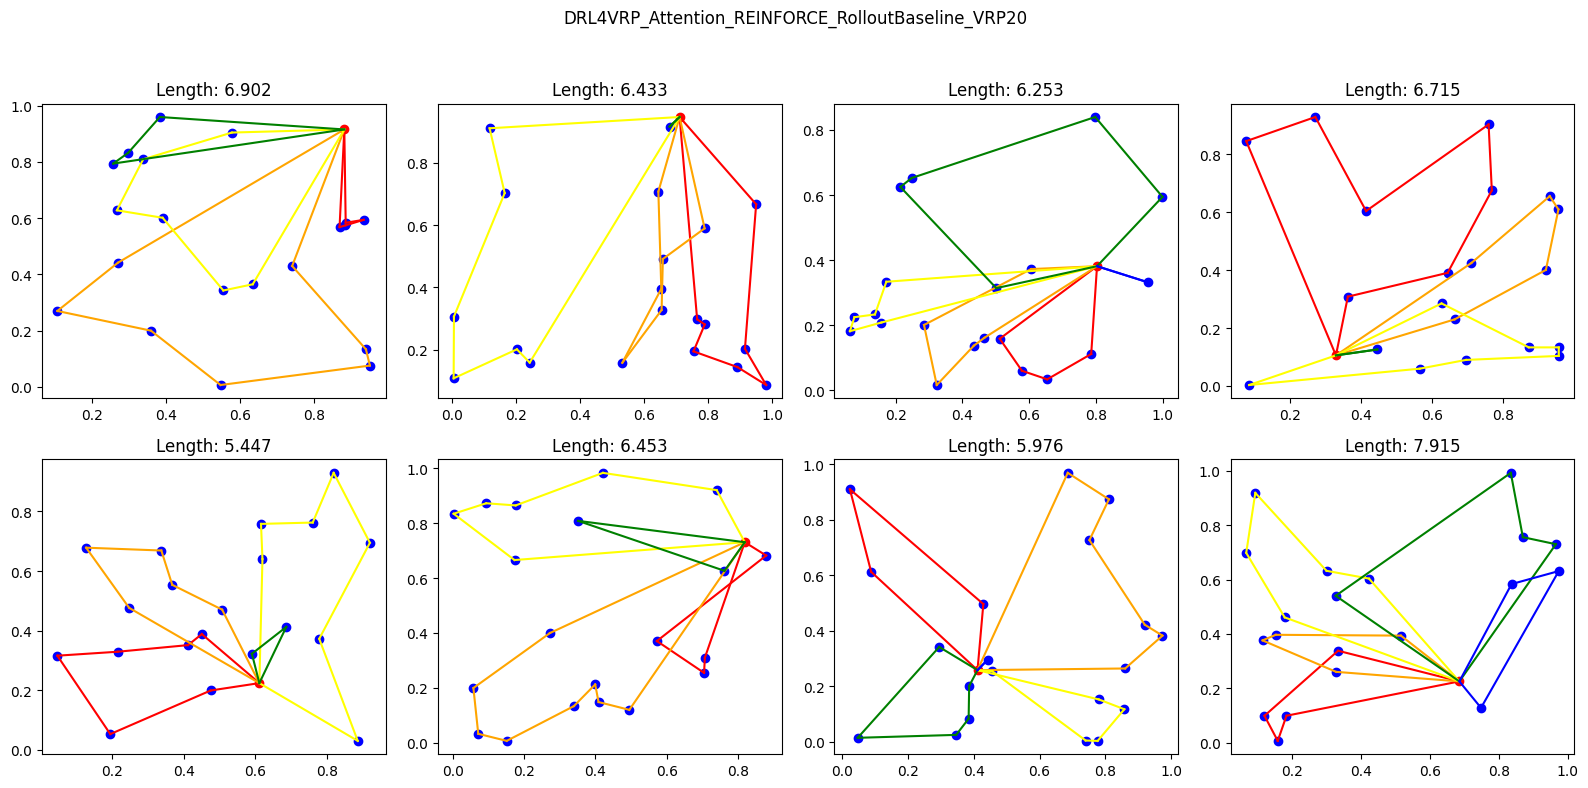

Test average reward: 6.5209
Test completed!


In [16]:
print('Test started...')
test1(args, test_dataset)
print('Test completed!')

In [17]:
# 测试 (sampling)
def sampling(actor, depot, customer, demand, num_samples, sub_batch_size=1280):
    # depot: (batch_size, 2)
    # customer: (batch_size, num_nodes, 2)
    # demand: (batch_size, num_nodes)
    batch_size = depot.size(0)
    best_idxs, best_rewards = [], []
    
    for i in range(batch_size):
        temp_depot = depot[i].unsqueeze(0)
        temp_customer = customer[i].unsqueeze(0)
        temp_demand = demand[i].unsqueeze(0)
        best_idx, best_reward = None, float('inf')
        
        num_sub_batches = (num_samples + sub_batch_size - 1) // sub_batch_size
        
        remaining_samples = num_samples
        for _ in range(num_sub_batches):
            current_batch_size = min(sub_batch_size, remaining_samples)
            remaining_samples -= current_batch_size
            
            temp_depots = temp_depot.repeat(current_batch_size, 1)
            temp_customers = temp_customer.repeat(current_batch_size, 1, 1)
            temp_demands = temp_demand.repeat(current_batch_size, 1)
            temp_rewards, temp_idxs, _ = actor(temp_depots, temp_customers, temp_demands.clone())
            
            sub_best_reward, sub_best_idx = temp_rewards.min(0)
            sub_best_reward = sub_best_reward.item()
            sub_best_idx = temp_idxs[sub_best_idx]
            
            if sub_best_reward < best_reward:
                best_idx = sub_best_idx
                best_reward = sub_best_reward
            
        best_idxs.append(best_idx)
        best_rewards.append(best_reward)
    
    return torch.tensor(best_rewards, device=depot.device), best_idxs
        

def test2(args, test_dataset):
    test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)
    
    actor = Actor(args.num_heads, args.embedding_size, args.num_layers, args.input_size, args.FF_hidden_size, args.normalization, args.dropout, update_vrp, args.C, args.temperature, False, reward).to(args.device)
    actor.load_state_dict(torch.load(os.path.join(args.output_dir, args.name)))
    
    actor.eval()
    total_rewards, total_nums = 0, 0
    
    with torch.no_grad():
        for i, test_batch in enumerate(test_loader):
            depot = test_batch[0].to(args.device)
            customer = test_batch[1].to(args.device)
            demand = test_batch[2].to(args.device)
            rewards, idxs = sampling(actor, depot, customer, demand, args.num_samples)
            total_rewards += rewards.sum().item()
            total_nums += depot.size(0)
            
            if i == 0 and depot.size(0) >= 8:
                plot_vrp_paths(args, depot[:8], customer[:8], idxs[:8], rewards[:8])
            
    avg_reward = total_rewards / total_nums
    print(f"Test average reward (sampling): {avg_reward:.4f}")

Test started...


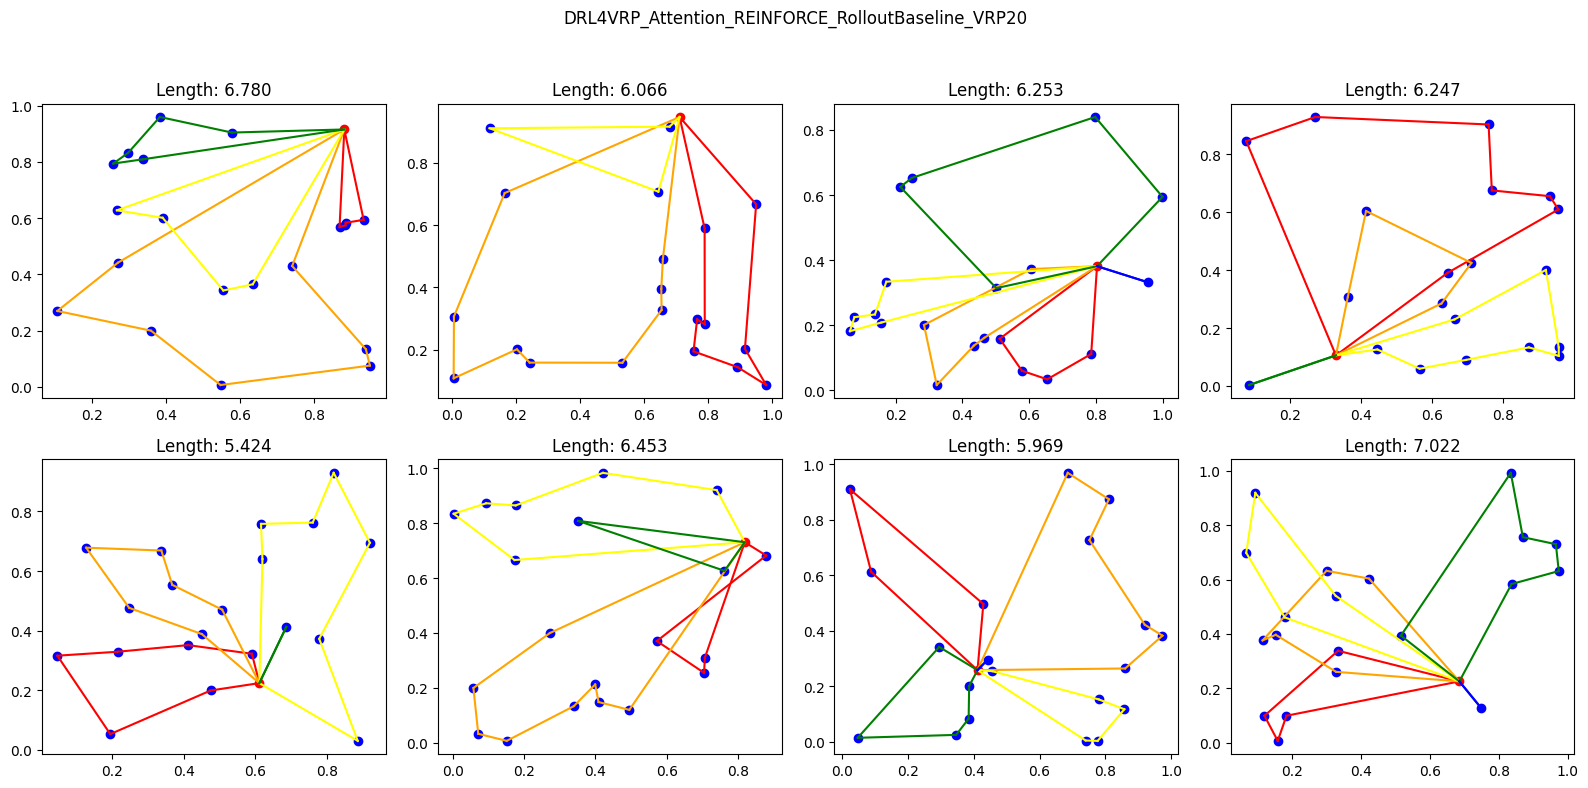

Test average reward (sampling): 6.3305
Test completed!


In [18]:
print('Test started...')
test2(args, test_dataset)
print('Test completed!')